# Gibbs chain verification

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from functools import partial
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_LiteBIRD_64 import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


# Studying the sampling !

In [4]:
# file_ver = 'full_v9_classGchain_SO_noise_v6a' # -> 10 iterations, seed 43, 1c toml file, step-size_r 1e-4 + reduced noise by 100 + classGibbs + test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v9_Gchain_SO_noise_v7a' # -> 10 iterations +  test_full_chain_v1b ; reduced noise by 100 + test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
sub_step_sampling = 1
reduction_noise = 1
path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
file_ver = 'full_v9_Gchain_SO_noise_v7b' # -> 1000 iterations +  test_full_chain_v1b ; reduced noise by 100 + test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
sub_step_sampling = 50
path_toml_file = directory_toml_file + 'test_full_chain_v1b.toml'
file_ver = 'full_v9_Gchain_SO_noise_v7c' # -> 1000 iterations +  test_full_chain_v1b ; reduced noise by 100 + test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v9_Gchain_SO_noise_v7c_alt' # -> 1000 iterations +  test_full_chain_v1b ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v9_Gchain_SO_noise_v7d_alt' # -> 1000 iterations + gap=5 +  test_full_chain_v1b ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v9_biased_Gchain_SO_noise_v8a' # -> 1000 iterations +  test_full_chain_v1b ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
path_toml_file = directory_toml_file + 'test_biased_full_chain_v1a.toml'
file_ver = 'full_v91_Gchain_SO_64_v9a' # -> 3000 iterations + no_gap +  test_full_chain_v1c ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v91_Gchain_SO_64_v9b' # -> 4000 iterations + gap=4 + test_full_chain_v1c + initial_guess_r = 1e-3 ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
file_ver = 'full_v91_Gchain_SO_64_v10a' # -> 1000 iterations + gap=4 + test_full_chain_v1d + initial_guess_r = 1e-3 ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
file_ver = 'full_v91_Gchain_SO_64_v9c' # -> 4000 iterations + gap=4 + test_full_chain_v1c + initial_guess_r = 1e-2 ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v91_Gchain_SO_64_v9d' # -> 10000 iterations + 10% error + test_full_chain_v1c + initial_guess_r = 1e-2 ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
file_ver = 'full_v91_Gchain_SO_64_v9e' # -> 2000 iterations + 10% error + test_full_chain_v1c + initial_guess_r = 1e-7 ; test_full_chain_v1a + C_approx only lensing ; start_r=10**(-2) + exact values B_f
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
# file_ver = 'full_v91_Gchain_SO_64_v10c' # -> 10000 iterations + 10% error + test_full_chain_v1d + initial_guess_r = 1e-2 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v10d' # -> 2000 iterations + 10% error + test_full_chain_v1d + initial_guess_r = 1e-7 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v10e' # -> 5000 iterations + 10% error + test_full_chain_v1d + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1d.toml'
file_ver = 'full_v91_Gchain_SO_64_v10f' # -> 4000 iterations + 10% error + test_full_chain_v1e + non-automated step-size + initial_guess_r = 1e-8 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v10g' # -> 4000 iterations + 10% error + step-size_r 1e^-4 + test_full_chain_v1e + non-automated step-size + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1e.toml'
# file_ver = 'full_v91_Gchain_SO_64_v9f' # -> 8000 iterations + 10% error + test_full_chain_v1c + initial_guess_r = 1e-8 ; C_approx only lensing
# path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
# file_ver = 'full_v91_Gchain_SO_64_v9g' # -> 5000 iterations + 10% error + test_full_chain_v1eb + initial_guess_r = 1e-8 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v9i' # -> 3000 iterations + 10% error + test_full_chain_v1fb + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1eb.toml'
file_ver = 'full_v91_Gchain_SO_64_v11b' # -> 1500 iterations + 1% error + step-size_r 1e^-4 + test_full_chain_v1ec + non-automated step-size + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1ec.toml'
file_ver = 'full_v91_Gchain_SO_64_v10h' # -> 2000 iterations + 10% error + step-size_r 1e^-3 + test_full_chain_v1fa + initial_guess_r = 1e-8 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v10i' # -> 5000 iterations + 10% error + step-size_r 1e^-3 + test_full_chain_v1fa + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1fa.toml'
# file_ver = 'full_v91_Gchain_SO_64_v9i' # -> 2000 iterations + 10% error + test_full_chain_v1f + step-size_r=1e^-3 + initial_guess_r = 1e-8 ; C_approx only lensing
file_ver = 'full_v91_Gchain_SO_64_v9j' # -> 5000 iterations + 10% error + test_full_chain_v1f + step-size_r=1e^-3 + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1f.toml'
file_ver = 'full_v91_Gchain_SO_64_v10j' # -> 3000 iterations + 10% error + step-size_r 1e^-3 + test_full_chain_v1ga + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1ga.toml'
file_ver = 'full_v91_Gchain_SO_64_v11c' # -> 4000 iterations + 10% error + test_full_chain_v1g + step-size_r=1e^-3 + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1g.toml'
file_ver = 'full_v91_Gchain_SO_64_v11d' # -> 3000 iterations + 10% error + test_full_chain_v1gb + step-size_r=1e^-3 + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1gb.toml'
file_ver = 'full_v91_Gchain_SO_64_v11e' # -> BIASED!!! - 2000 iterations + 10% error + test_full_chain_v1gd + step-size_r=1e^-3 + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1gd.toml'
file_ver = 'full_v91_Gchain_SO_64_v10k' # -> 4000 iterations + 10% error + step-size_r 1e^-3 + test_full_chain_v1gc + initial_guess_r = 1e-8 ; C_approx only lensing
path_toml_file = directory_toml_file + 'test_full_chain_v1gc.toml'


In [5]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [6]:
if (MICMAC_sampler_obj.number_iterations_sampling > 100) and (sub_step_sampling==1):
    sub_step_sampling = 50
elif MICMAC_sampler_obj.number_iterations_sampling > 1000:
    sub_step_sampling = 100

In [7]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [8]:
# input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# # input_cmb_maps = input_cmb_maps_alt
# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')
# freq_maps = input_cmb_maps + freq_maps_fgs
# freq_maps = np.load(directory_save_file+file_ver+'_initial_data.npy')


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [9]:
initial_freq_maps_path = directory_save_file+file_ver+'_initial_data.npy'
initial_freq_maps = np.load(initial_freq_maps_path)

initial_cmb_maps_path = directory_save_file+file_ver+'_initial_cmb_data.npy'
input_cmb_maps = np.load(initial_cmb_maps_path)
if not(MICMAC_sampler_obj.cheap_save):
    all_eta_maps_path = directory_save_file+file_ver+'_all_eta_maps.npy'
    all_eta_maps = np.load(all_eta_maps_path)

    all_s_c_WF_maps_path = directory_save_file+file_ver+'_all_s_c_WF_maps.npy'
    all_s_c_WF_maps = np.load(all_s_c_WF_maps_path)

    all_s_c_fluct_maps_path = directory_save_file+file_ver+'_all_s_c_fluct_maps.npy'
    all_s_c_fluct_maps = np.load(all_s_c_fluct_maps_path)

    all_cell_samples_path = directory_save_file+file_ver+'_all_cell_samples.npy'
    all_cell_samples = np.load(all_cell_samples_path)
elif not(MICMAC_sampler_obj.very_cheap_save):
    all_s_c_path = directory_save_file+file_ver+'_all_s_c.npy'
    all_s_c_samples = np.load(all_s_c_path)
all_r_samples_path = directory_save_file+file_ver+'_all_r_samples.npy'
all_r_samples = np.load(all_r_samples_path)

all_params_mixing_matrix_samples_path = directory_save_file+file_ver+'_all_params_mixing_matrix_samples.npy'
all_params_mixing_matrix_samples = np.load(all_params_mixing_matrix_samples_path)


In [10]:
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_sampling_step_4/fisher_litebird_d0s0_lmin2_lmax128_masked_Alens1.0_r0.0_B_noiselens_synchdust.txt'
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/fisher_so-sat_d0s0_lmin2_lmax128_nomask_Alens1.0_r0.0_B_noiselens.txt'
# Fisher_matrix = np.loadtxt(path_Fisher)

# minimum_std_Fisher = scipy.linalg.sqrtm(np.linalg.inv(Fisher_matrix))
# minimum_std_Fisher_diag = np.diag(minimum_std_Fisher)
# print(minimum_std_Fisher_diag)

In [11]:

# Getting C_approx and a first guess for C
input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]),input_cmb_maps[0]])

c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]


# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)
number_steps_sampler = 100


# Noise initialization
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [12]:
eye_Stokes_personalized = np.eye(MICMAC_sampler_obj.nstokes)
if MICMAC_sampler_obj.only_select_Bmodes:
    eye_Stokes_personalized[0,0] = 0

In [13]:
number_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [14]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter

## Testing $\eta$

In [15]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

In [16]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

red_cl_noise_harm = np.zeros_like(red_cov_approx_matrix)
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

        cl_noise = BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2
        red_cl_noise_harm[:] = np.diag([cl_noise,cl_noise])
        full_cl_noise = np.zeros_like(c_ell_approx)
        full_cl_noise[:MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.lmin:] = cl_noise

        # analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
        analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

        # analytical_eta_term = np.zeros_like(c_ell_approx)
        analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]

        eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[iteration,0,...]), all_eta_maps[iteration]])
        c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(7,5))
        plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            ax = plt.subplot(311+j)
            plt.title(list_correl[j])
            
            plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')

            plt.plot(ell_arange, c_ell_approx[j,MICMAC_sampler_obj.lmin:], label='c_ell_approx')
            # plt.plot(ell_arange, full_cl_noise[j,MICMAC_sampler_obj.lmin:], label='c_ell N_c')
            plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")

            plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

            if MICMAC_sampler_obj.nstokes == 3 and j < number_correl_to_plot-2:
                plt.xticks(color='w')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                # plt.ylim(ymin=noise_level/10.)
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.legend()
            if j == position_legend:
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            
            plt.ylabel("$C_\ell$ [$uK^2$]")
            if j == number_correl_to_plot-1:
                plt.xlabel(r"$\ell$")
        plt.show()

# Validation $s_c$

In [17]:
all_params_mixing_matrix_samples[0].ravel(order='F').reshape((4,2),order='F')

array([[0.31939603, 0.0094117 ],
       [0.03253226, 0.05511086],
       [0.00978005, 0.13522384],
       [0.00303524, 0.4788799 ]])

In [18]:
# [[0.33858815 0.00979233]
#  [0.02963068 0.05147511]
#  [0.00998213 0.12913911]
#  [0.00328725 0.44076761]]

In [19]:
initial_freq_maps.shape

(6, 2, 49152)

In [20]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        

        red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                            analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(14,8))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(331+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('WF term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()

            plt.subplot(332+3*j)
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Fluctuation term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()
            
            plt.subplot(333+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")

            plt.xlabel(r"$\ell$")
            plt.legend()
        plt.show()

In [21]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.very_cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        

        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
        #                                                                     analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        # analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        # analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        # analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        # s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        # c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        # c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        # s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        s_c_recovered = all_s_c_samples[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(10,5))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(311+j)
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            
            plt.xlabel(r"$\ell$")
            


        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


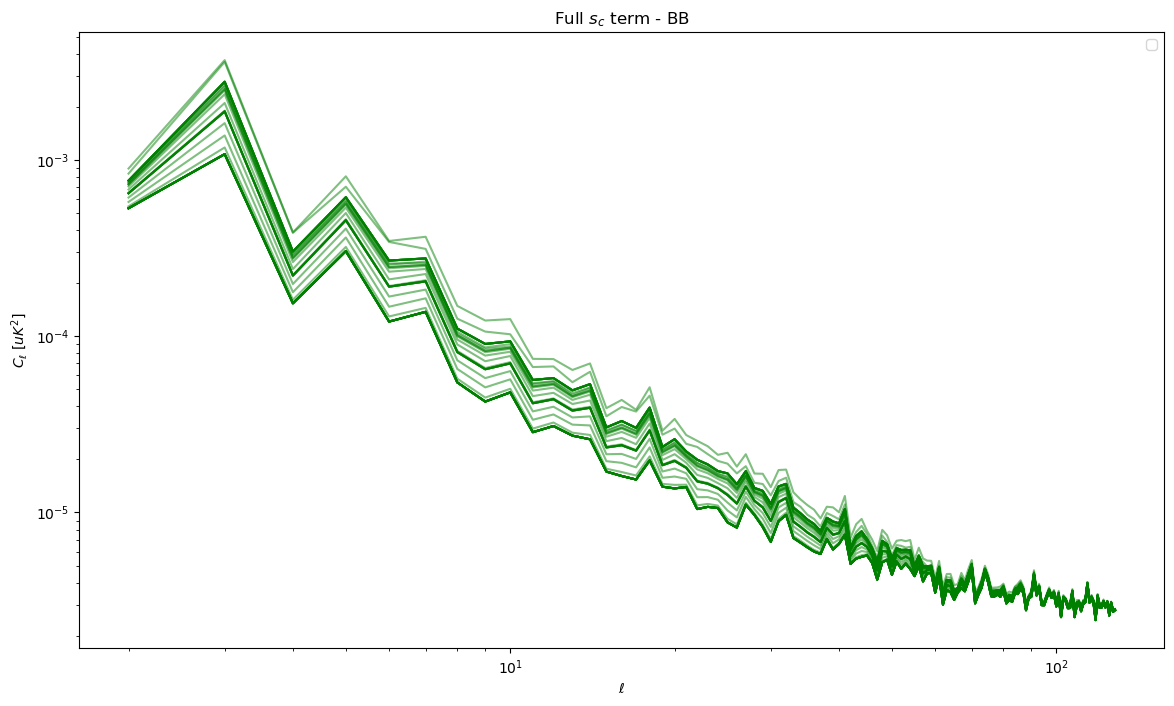

In [22]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

plt.figure(figsize=(14,8))
for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
    covariance_noise = np.zeros_like(c_ell_approx)

    # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[MICMAC_sampler_obj.lmin:]
    mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
    if iteration != 0:
        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
    mixing_matrix_sampled = mixing_matrix_obj.get_B()
    BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
    BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
    BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
    s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]

    # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
    full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
    c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
    # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
    # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)

    # analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
    # analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
    # analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

    # s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
    # c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
    # c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
    # s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
    # s_c_recovered = all_s_c_samples[iteration,...]
    # s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
    # c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

    # plt.figure(figsize=(14,8))
    # plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

    # for j in range(number_correl_to_plot):
        # plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
        # plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ell_s_cML.shape[-1])+lmin, c_ell_s_cML[1,:], 'g', alpha=.5)

# if j <= nstokes-1:
#     plt.loglog()
#     plt.plot([lmin,lmax+1], [0,0], 'k:')
# else:
#     plt.xscale('log')
#     plt.yscale('symlog')
#     plt.plot([lmin,lmax+1], [0,0], 'k:')
plt.title('Full $s_c$ term - {}'.format(list_correl[1]))
plt.ylabel("$C_\ell$ [$uK^2$]")
plt.xlabel(r"$\ell$")
plt.loglog()
plt.legend()


plt.show()

# Plot $C$

In [23]:
map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

In [24]:
# list_correl = ['EE', 'BB', 'EB']

# ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin
# min_value_mean = 3
# factor_mean = (2*ell_arange[min_value_mean:] + 1)/(2*ell_arange[min_value_mean:] + 1 - 2 - 2*nstokes)

# for iteration in range(0,number_iterations_sampling,sub_step_sampling):
#     covariance_noise = np.zeros_like(c_ell_approx)

#     mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
#     mixing_matrix_sampled = mixing_matrix_obj.get_B()
#     BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
#     BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
#     BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
#     s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0]
#     full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
#     # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[lmin:]

#     full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
#     c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

#     full_map_s_c_extended = np.vstack([np.zeros_like(full_map_s_c[0,...]), full_map_s_c])
#     c_ell_s_c = hp.anafast(full_map_s_c_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

#     plt.figure(figsize=(10,5))
#     plt.suptitle(r"Little study $C$ for iteration {}".format(iteration))

#     for j in range(number_correl_to_plot):
#         ax = plt.subplot(311+j)
#         plt.title(list_correl[j])

#         plt.plot(ell_arange[min_value_mean:], c_ell_s_c[j,min_value_mean:]*factor_mean, label='Mean value invWishart')
#         plt.plot(ell_arange, c_ell_s_cML[j,...], label='$s_{c,ML}$')
#         plt.plot(ell_arange, all_cell_samples[iteration,j,lmin:], '--', label='Sample C')
#         plt.plot(ell_arange, c_ell_true_CMB[j,...], ':', label='True CMB')
        
#         plt.ylabel("$C_\ell$ [$uK^2$]")
#         if j == number_correl_to_plot-1:
#             plt.xlabel(r"$\ell$")
#             plt.legend()
#             plt.xscale('log')
#             plt.yscale('symlog')
#         else:
#             plt.loglog()


#     plt.show()

In [25]:
# all_r_samples_2 = np.copy(all_r_samples)

In [26]:
# all_r_samples = np.zeros(MICMAC_sampler_obj.number_iterations_sampling+1)
# all_r_samples[0] = all_r_samples_2[0]
# all_r_samples[1:] = all_r_samples_2[9:]
# all_r_samples

# Studying $r$

In [27]:
all_r_samples[MICMAC_sampler_obj.num_sample_AM-1], all_r_samples[MICMAC_sampler_obj.num_sample_AM]

(0.04795725136559019, 0.048197207545049546)

In [28]:
all_r_samples[MICMAC_sampler_obj.num_sample_AM+1], all_r_samples[MICMAC_sampler_obj.num_sample_AM+2]

(0.048197207545049546, 0.048197207545049546)

In [29]:
all_r_samples[-1]

0.03153266631078671

In [30]:
# MICMAC_sampler_obj.number_iterations_sampling = 5000

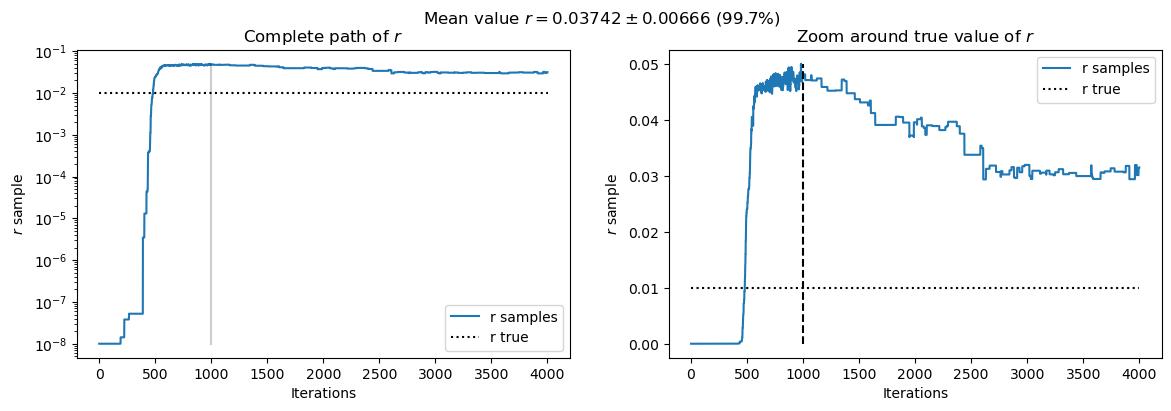

In [31]:
plt.figure(figsize=(14,4))
# mean_r = np.round(all_r_samples.mean(), decimals=5)
# std_r = np.round(all_r_samples.std(), decimals=5)
n_sigma = 3
transformed_samples = np.abs(all_r_samples - all_r_samples.mean())/(all_r_samples.std()) #< n_sigma
cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
mean_r = np.round(all_r_samples[cond].mean(), decimals=5)
std_r = np.round(all_r_samples[cond].std(), decimals=5)

plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%)")
plt.subplot(121)
plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples, label='r samples')
plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples.min(),all_r_samples.max()], color='black',alpha=.2)
plt.yscale('log')
plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title('Complete path of $r$')
plt.legend()

plt.subplot(122)
plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples, label='r samples')
plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples.min(),all_r_samples.max()], '--', color='black')
# plt.yscale('symlog')
plt.xlabel("Iterations")
plt.ylabel('$r$ sample')
plt.title('Zoom around true value of $r$')
plt.legend()
# plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
plt.show()

In [32]:
# initial_freq_maps_only_B = np.copy(initial_freq_maps)
# c_ell_select_only_Bmodes = np.zeros((6,lmax+1))
# c_ell_select_only_Bmodes[2,lmin:] = 1
# red_cov_select_Bmodes = micmac.get_reduced_matrix_from_c_ell(c_ell_select_only_Bmodes[indices_polar,...])[lmin:,...]
# for freq in range(number_frequencies):
#     initial_freq_maps_only_B[freq] = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(initial_freq_maps[freq]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

# input_cmb_maps_only_B = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(np.copy(input_cmb_maps[0]), red_cov_select_Bmodes, lmin=2, n_iter=n_iter)[1:,...]

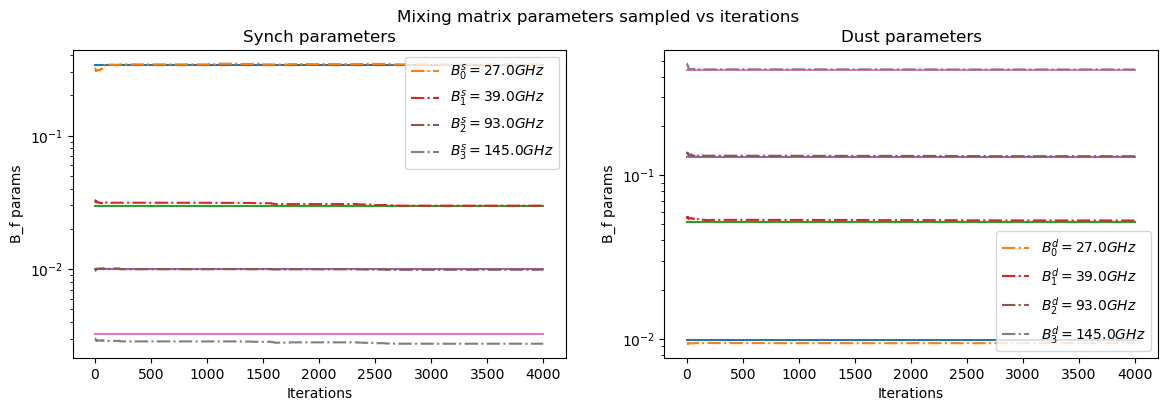

In [33]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = instrument['frequency'][1:-1]
all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

frequency_array = np.array(instrument['frequency'])


plt.figure(figsize=(14,4))
plt.suptitle('Mixing matrix parameters sampled vs iterations')
plt.subplot(121)
plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('B_f params')

plt.subplot(122)
plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
plt.legend()
# plt.loglog()
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('B_f params')
plt.show()


In [34]:
num_sample_AM = 1000

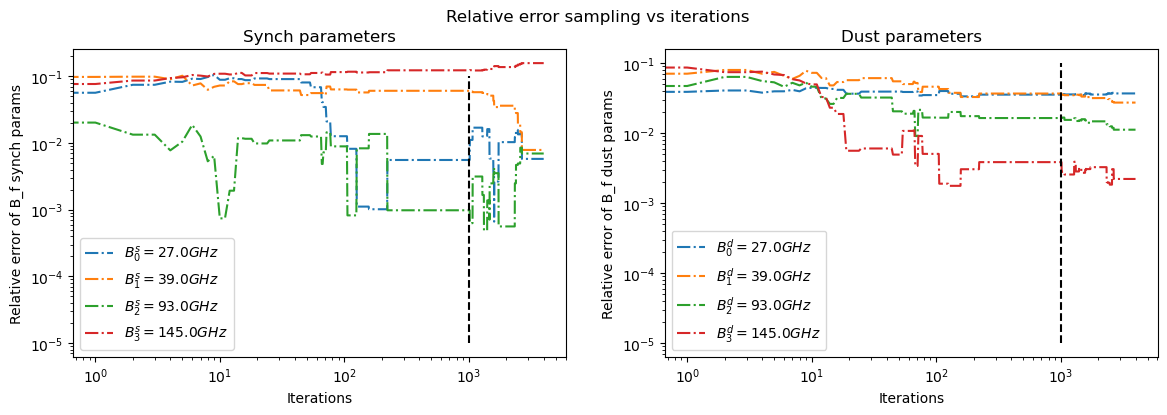

In [35]:
all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

plt.figure(figsize=(14,4))
plt.suptitle('Relative error sampling vs iterations')
plt.subplot(121)
plt.title(('Synch parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i,0])/init_params[i,0])
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')

plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
plt.loglog()
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f synch params')

plt.subplot(122)
plt.title(('Dust parameters'))
for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
    relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i,1])/init_params[i,1])
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
plt.legend()
plt.loglog()
plt.xlabel('Iterations')
plt.ylabel('Relative error of B_f dust params')
plt.show()


In [36]:
# final_params = all_params_mixing_matrix_samples[-1]
final_params = all_params_mixing_matrix_samples.mean(axis=0)
# final_params = all_params_mixing_matrix_samples[1000:].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[0]
# final_params = all_params_mixing_matrix_samples[:1000].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[1000]
# final_params = all_params_mixing_matrix_samples[:num_sample_AM].mean(axis=0)
# final_params = all_params_mixing_matrix_samples[num_sample_AM:].mean(axis=0)

mixing_matrix_obj.update_params(final_params)
final_mixing_matrix = mixing_matrix_obj.get_B()

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, initial_freq_maps, jax_use=False)[0, :, :]

mixing_matrix_obj.update_params(init_params)
init_mixing_matrix_obj = mixing_matrix_obj.get_B()
recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, initial_freq_maps, jax_use=False)[0, :, :]

residuals_Wd = recovered_CMB_Wd - input_cmb_maps[0]
residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[0]

recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


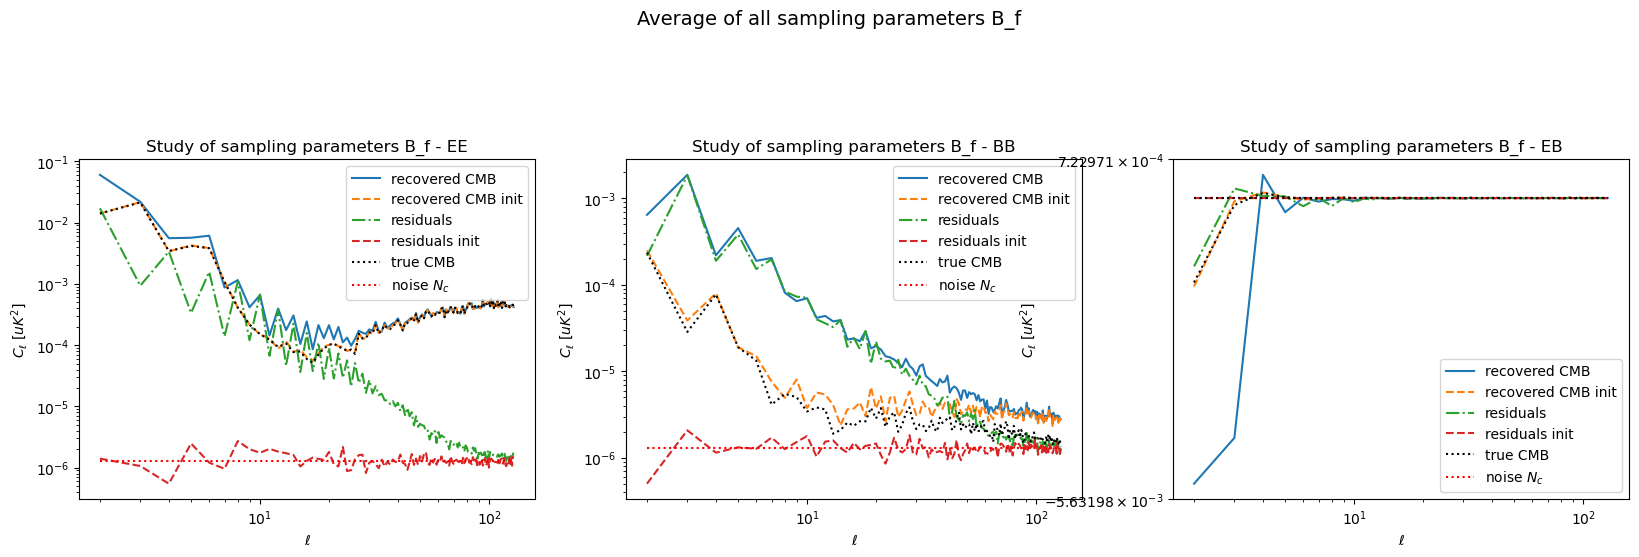

In [37]:
plt.figure(figsize=(20,15))
list_correl = ['EE', 'BB', 'EB']
plt.suptitle('Average of all sampling parameters B_f', fontsize=14)
number_subplots_convention = 331
for i in range(number_correl_to_plot):
    plt.subplot(number_subplots_convention+i)
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

    if i <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
plt.show()